In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

CSV_FILE = "books-corrected.csv" #! Using the corrected file, to actually experience everything (all the errors), start with the books.csv file which does not have the manually corrected data that allows it to read properly.

### Reading the data and fixing the data types

To catch as many errors as possible I propose recommend the following checklist:
- quick manual skim over the (csv) file
- make sure that the number of columns and rows match those of the data file
- check and fix column data types - this will save RAM (strings are expensive to store), allow you to do data type specific operations (you can't compute the difference between dates, or get the month easily, if the date is a string)
- check for NA values and determine what to do with them
- check for other data discrepancies (i.e. people with ages over 150, average ratings being < 0 etc.), one useful function here is `df.describe()` (not exhaustive!)

That being said, let's try and read the data. The first error is `ParserError: Error tokenizing data. C error: Expected 12 fields in line 390, saw 13`, indicating that line 390 has 13 columns instead of 12. Inspecting the line we can see an additional comma. As always, there are many possible ways to deal with such errors, we could delete the row, or just delete the comma. Let's delete the comma, as the row looks fine otherwise. 
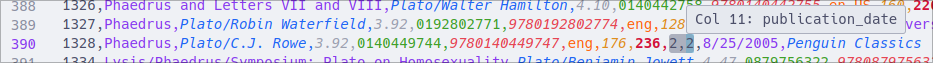

Pandas read_* functions have a lot of parameters, take a look at the documentation (e.g. for [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)) and get familiar with them. One useful parameter is `sep=""` which determines the separator of the columns (it doesn't have to be a comma, as it's not always practical, i.e. price data from EU uses decimal commas.).

Note: there were a few more such errors but I've fixed them in order to save time during the demonstration.

After loading let's take a look at the dataframe and the column data types. When you want to print multiple things inside one notebook cell (and keep the formatting), use `display()` (from the `jupyter` package) instead of `print()`, because it doesn't ruin the formatting (it displays dataframes and other things nicely formatted).

Note: displaying just the top (`df.head()`) or bottom part (`df.tail()`) of a dataframe can hide things about your data, as the table you get usually has some kind of ordering. Here, it could be ordered by average_rating, and if you display only the top portion with `df.head()` you may not see that the tail has multiple books with average_rating > 0 while simultaneously having 0 ratings_count which doesn't make sense. Therefore I recommend printing the dataframe object directly as it displays a few starting and a few ending rows.

In [2]:
df = pd.read_csv(CSV_FILE)
display(df)
df.dtypes

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11120,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11121,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11122,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11123,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


bookID                 int64
title                 object
authors               object
average_rating        object
isbn                  object
isbn13                object
language_code         object
num_pages             object
ratings_count          int64
text_reviews_count     int64
publication_date      object
publisher             object
dtype: object

Looking at the datatypes above, we can notice that some are wrong:
- the `publication_date` should be a datetime and not a generic string (object)
- `average_rating` should be a decimal number (float)
- `num_pages` should be a whole number (int)

Let's fix them. Starting with the date, if we try to parse the column to datetime we get the following error: `ValueError: day is out of range for month, at position 8180.`. If we take a look around that line (sometimes the position is a bit off due to not counting the header and the indexing starting with 0 etc.), we can see that indeed the date is November 31st, which isn't possible as November has only 30 days. Again, we have multiple options, we could look up the book by the isbn and look at the publisher date on the internet and manually fix it, or we can just drop the row. Let's drop it.

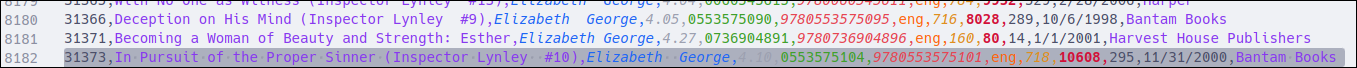


In [3]:
df["publication_date"] = pd.to_datetime(df["publication_date"])

Next, let's see if we can parse the number of pages to an int. We get the following error `ValueError: invalid literal for int() with base 10: 'en-US'`. It looks like there is something wrong with the formatting of the csv, but to speed up, we will just see how many rows are problematic, and if the number is low enough, drop all of them. We find there are only 4 such rows, so we drop them.

Note: here you can see how commas can pose problems in csv files. The book with id 16914 has authors `David E. Smith (Turgon of TheOneRing.net COMMA HERE one of the founding members of this Tolkien w...`, and because that string includes a comma, it messes up the columns (assigns the second portion of the string to the average_rating, which is also why average_rating wasn't automatically parsed to a float).

In [4]:
# df["num_pages"] = df["num_pages"].astype(int)
print(f'How many rows have promlematic num_pages: {sum(~df["num_pages"].str.isnumeric())} out of {len(df)}.')
display(df[~df["num_pages"].str.isnumeric()])
df = df[df["num_pages"].str.isnumeric()]
df["num_pages"] = df["num_pages"].astype(int)

How many rows have promlematic num_pages: 4 out of 11125.


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
3348,12224,Streetcar Suburbs: The Process of Growth in Bo...,Sam Bass Warner,Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,616,2004-04-20,Harvard University Press
4702,16914,The Tolkien Fan's Medieval Reader,David E. Smith (Turgon of TheOneRing.net,one of the founding members of this Tolkien w...,3.58,1593600119,9781593600112,eng,400,264,2004-04-06,Cold Spring Press
5877,22128,Patriots (The Coming Collapse),James Wesley,Rawles,3.63,156384155X,9781563841552,eng,342,384,1999-01-15,Huntington House Publishers
8978,34889,Brown's Star Atlas: Showing All The Bright Sta...,Brown,Son & Ferguson,0.00,0851742718,9780851742717,eng,49,0,1977-05-01,Brown Son & Ferguson Ltd.


Finally, let's fix `average_rating`.

Note: if you run this cell before the above cell (so before dropping the non numeric `num_pages` rows), it also fails, but since the problematic rows were dropped by to fix num pages, as a side effect average_ratings were also fixed. Be mindful of such side effects as they can be dangerous.

In [5]:
df["average_rating"] = df["average_rating"].astype(float)

Taking one final look at the column data types, they seem fine.

In [6]:
df.dtypes

bookID                         int64
title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                        object
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
dtype: object

### NA values

Checking for rows with any NA values, we can see there aren't any so we can skip this part. However, always check this, and once you discover some NA values question, if these are an error or indicate something else (maybe the measurement of that column doesn't make sense in that row etc.) before blindly dropping them.

In [7]:
display(df[df.isna().any(axis=1)])

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher


**The errors above were all already in the original dataset (I just fixed/changed a few of them so the DEMO can go smoother)**

### Descriptive statistics

Let's see the ranges of our numerical values, to see if they align with our expectations.

We can immediately see that the average ratings have a minimum of -4.07 and a maximum of 40.04. This is an error I introduced, and it is easily caught by `df.describe()`, however, don't count on errors being this easy to spot. It would make sense to do deeper analysis (e.g. look at the distributions).

Displaying the rows that have average_rating outside the \[0,5] interval, we can see there are only 2 such rows and we can just drop them.

In [8]:
df.describe()
display(df[(df["average_rating"] < 0) | (df["average_rating"] > 5)])
df = df[(df["average_rating"] >= 0) & (df["average_rating"] <= 5)]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
710,2299,Emergence: Labeled Autistic,Temple Grandin/Margaret M. Scariano,-4.07,0446671827,9780446671828,en-GB,200,1827,154,1996-09-01,Grand Central Publishing
1100,3731,Great Short Works of Herman Melville,Herman Melville/Warner Berthoff,40.04,0060586540,9780060586546,eng,512,424,13,2004-03-02,Harper Perennial Modern Classics


### Some basic computations

Here, I just wanted to provide a few exercises, the emphasis is not on statistical rigour or value they provide, but rather on just doing them.

#### Days since the book has been published

This is why column data types are important, as now we can do a difference between the current date time and the publication date time.

In [9]:
df["days_since_publication"] = (datetime.now() - df["publication_date"]).dt.days

#### Number of authors of each book

Just to showcase working with string columns. Here books can have multiple authors and they are separated with a `/`. So to get the number of authors, we can split the string into an array of authors (1 element = 1 author) and look at the length of the array.

Note: always eyeball if the transformation you performed is correct.

Note: here we see an example of why notebooks can encourage/allow bad programming. The line `df["authors"] = df["authors"].str.split("/")` can only ever be executed once on this dataset, because the transformation only works when the `authors` column is a string. Once we change the rows into string arrays with `.str.split('/')`, the `.str` property doesn't exist anymore. This is why you should always restart the kernel and rerun your whole notebook to check if you can even execute it from a cold start.

In [10]:
df["authors"] = df["authors"].str.split("/")
df["num_authors"] = df["authors"].apply(len)
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,days_since_publication,num_authors
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,6245,2
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,6990,2
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,7295,1
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,7113,2
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,6978,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11120,45631,Expelled from Eden: A William T. Vollmann Reader,"[William T. Vollmann, Larry McCaffery, Michael...",4.06,1560254416,9781560254416,eng,512,156,20,2004-12-21,Da Capo Press,6879,3
11121,45633,You Bright and Risen Angels,[William T. Vollmann],4.08,0140110879,9780140110876,eng,635,783,56,1988-12-01,Penguin Books,12743,1
11122,45634,The Ice-Shirt (Seven Dreams #1),[William T. Vollmann],3.96,0140131965,9780140131963,eng,415,820,95,1993-08-01,Penguin Books,11039,1
11123,45639,Poor People,[William T. Vollmann],3.72,0060878827,9780060878825,eng,434,769,139,2007-02-27,Ecco,6081,1


### Computing an average rating of each author

The easiest approach is to just compute the average of `average_rating` of each author. Remember, our `authors` values are now string arrays with each element being an author. If we want to compute an average rating for each author, we can't just blindly say `df["authors"] == NAME`, as the `df["authors"]` is an array, and it may have multiple elements.

To solve this we can use `df.explode("authors")` which takes a row, and creates an identical copy of the whole row for each of the authors.

In [11]:
print('Before')
display(df)
print('After')
display(df.explode("authors"))
print('Result')
display(df.explode("authors").groupby("authors")["average_rating"].mean().sort_values(ascending=False))


Before


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,days_since_publication,num_authors
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,6245,2
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,6990,2
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,7295,1
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,7113,2
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,6978,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11120,45631,Expelled from Eden: A William T. Vollmann Reader,"[William T. Vollmann, Larry McCaffery, Michael...",4.06,1560254416,9781560254416,eng,512,156,20,2004-12-21,Da Capo Press,6879,3
11121,45633,You Bright and Risen Angels,[William T. Vollmann],4.08,0140110879,9780140110876,eng,635,783,56,1988-12-01,Penguin Books,12743,1
11122,45634,The Ice-Shirt (Seven Dreams #1),[William T. Vollmann],3.96,0140131965,9780140131963,eng,415,820,95,1993-08-01,Penguin Books,11039,1
11123,45639,Poor People,[William T. Vollmann],3.72,0060878827,9780060878825,eng,434,769,139,2007-02-27,Ecco,6081,1


After


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,days_since_publication,num_authors
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,6245,2
0,1,Harry Potter and the Half-Blood Prince (Harry ...,Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,6245,2
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,6990,2
1,2,Harry Potter and the Order of the Phoenix (Har...,Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,6990,2
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,7295,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11120,45631,Expelled from Eden: A William T. Vollmann Reader,Michael Hemmingson,4.06,1560254416,9781560254416,eng,512,156,20,2004-12-21,Da Capo Press,6879,3
11121,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,1988-12-01,Penguin Books,12743,1
11122,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,1993-08-01,Penguin Books,11039,1
11123,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2007-02-27,Ecco,6081,1


Result


authors
R. McL. Wilson                          5.0
William C. Dowling                      5.0
Chris    Green                          5.0
David Sylvester                         5.0
Middlesex Borough Heritage Committee    5.0
                                       ... 
Richard Wagner                          0.0
Andrew      Hunt                        0.0
Jasmine C.M. Luk                        0.0
Open City Magazine                      0.0
James Beckett III                       0.0
Name: average_rating, Length: 9228, dtype: float64

The above method of ranking isn't very good, as an author with one book rated 5 by 1 reviewer will have a higher average_rating than an author with 20 books rated 12340 times with an average_rating of 4.6. As seen below:

In [12]:
df.explode("authors").groupby("authors").agg({"average_rating": "mean", "ratings_count": "sum"}).sort_values(by=["average_rating", "ratings_count"], ascending=[False, False])

,average_rating,ratings_count
authors,,
John Diamond,5.0,5
Elena N. Mahlow,5.0,4
Alisa Klayman-Grodsky,5.0,2
Dennis Adler,5.0,2
Eric Weiner,5.0,2
...,...,...
Rick Osborne,0.0,0
Robert A. Weiss,0.0,0
Strawberry Saroyan,0.0,0


Can you come up with a better rating approach?

To illustrate one more, we will compute a score of an author by multiplying his/her average average_rating with the total number of ratings. Again, this isn't perfect as an author could've written 100 books rated poorly and have a higher score than an author with 10 books rated better.

Note: here the score lives on the interval [0, inf). This is bad as it can cause all sorts of errors (e.g integer overflow, if comparing dimensions the score dimension will have a higher influence just due to the sheer range of values it can achieve etc.). You should have a bounded score, preferably on the unit interval.

In [13]:
author_stats = df.explode("authors").groupby("authors").agg(
    average_rating=("average_rating", "mean"),
    total_ratings=("ratings_count", "sum"),
)
author_stats["score"] = author_stats["average_rating"] * author_stats["total_ratings"]
author_stats.sort_values(by="score", ascending=False)

,average_rating,total_ratings,score
authors,,,
J.K. Rowling,4.500000,9265287,4.169379e+07
Mary GrandPré,4.548333,8923980,4.058924e+07
J.R.R. Tolkien,4.218000,5622283,2.371479e+07
Stephen King,4.008687,4288299,1.719045e+07
Stephenie Meyer,3.590000,4597666,1.650562e+07
...,...,...,...
Nayantara Sahgal,2.980000,0,0.000000e+00
Sean Doolittle,3.580000,0,0.000000e+00
João Guimarães Rosa,4.330000,0,0.000000e+00


Do you notice something weird about the above results?

How come `Sean Doolittle` has an average review of 3.58 while having 0 total ratings? At this point you should investigate and find out:
- is the average rating computed only from the ratings counted by total_ratings?
- is there an error in our computation causing this (e.g. if a book with multiple authors receives a rating, does that rating increment only the first author's rating_count or from all the authors of the book?)
- is this an error in the dataset and those authors should be dropped?

In [14]:
author_stats = author_stats[author_stats["total_ratings"] > 0]
author_stats.sort_values(by="score", ascending=False)

,average_rating,total_ratings,score
authors,,,
J.K. Rowling,4.500000,9265287,4.169379e+07
Mary GrandPré,4.548333,8923980,4.058924e+07
J.R.R. Tolkien,4.218000,5622283,2.371479e+07
Stephen King,4.008687,4288299,1.719045e+07
Stephenie Meyer,3.590000,4597666,1.650562e+07
...,...,...,...
Mymi Doinet,2.000000,1,2.000000e+00
Konrad Eisenbichler,2.000000,1,2.000000e+00
R.R. Palmer,2.000000,1,2.000000e+00


### Some basic visualization

Again, the emphasis is not on the informativeness, but rather on practising and giving some tips.

Below we draw a histogram of average ratings and save it. You should always save to a vector format unless you have a specific reason not to (e.g. sometimes it's hard to embed a pdf into a webpage, you should try resorting to .svg first).

To see the difference between raster and vector images, try zooming into `average_rating.png`, `average_rating_dpi300.png` and `average_rating.pdf`.

Make sure to manually check the saved visualization files to see if everything is displayed. matplotlib sometimes won't display some bars if they are too thin (again, vector images, after that, play with the size of the figure).

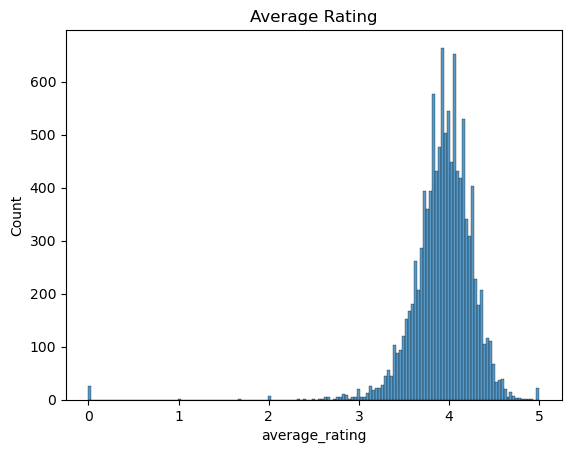

In [15]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="average_rating", ax=ax)
ax.set_title("Average Rating")
# plt.savefig("average_rating.png", dpi=300) # make sure to set the dpi high enough
plt.savefig("average_rating.pdf") # this is better, always prefer vector formats (.pdf, .svg) over raster ones (.png, .jpg)

### An example of improving a visualization

Let's draw a histogram of the top 10 most popular languages of the books in the GoodReads dataset.

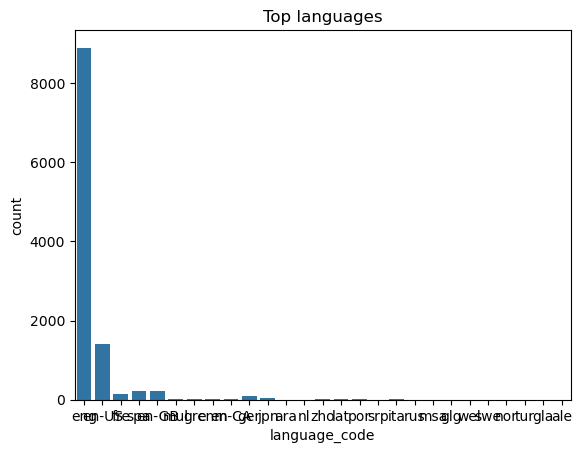

In [16]:
# count plot of languages
fig, ax = plt.subplots()
sns.countplot(data=df, x="language_code", ax=ax)
ax.set_title("Top languages")
plt.savefig("languages_starting.pdf")

Let's list some things that could be improved on the above visualization:
- the values (counts) should be sorted decreasingly
- the language labels are overlapping, we could increase the size of the figure, however let's try a horizontal barplot first to hopefully make the labels more readable.
- the language labels are a bit clunky (what language is `mul` - if you check the dataset page, it actually means "multiple languages"! Do we even include this in the top 10 language chart? Do we count en-US and en-GB as different langauges? etc.), let's map them to something more readable.
- the title `Top lanugages` brings no value. This is already obvious from the labels, maybe you could do "Top 10 most written in languages in the Goodreads dataset" or something like that (to indicate there are actually more languages, but these are the top 10).
- it would be good to at the actual count next to the bar
- ...



In [17]:
lang_map = { # non exhaustive list for DEMO speed
    'eng': 'English',
    'en-US': 'English',
    'en-GB': 'English',
    'fre': 'French',
    'spa': 'Spanish',
    'ger': 'German',
    'jpn': 'Japanese',
    'mul': 'Multiple Languages',
    'grc': 'Greek',
    'ara': 'Arabic',
}
df["language_code"] = df["language_code"].map(lang_map)


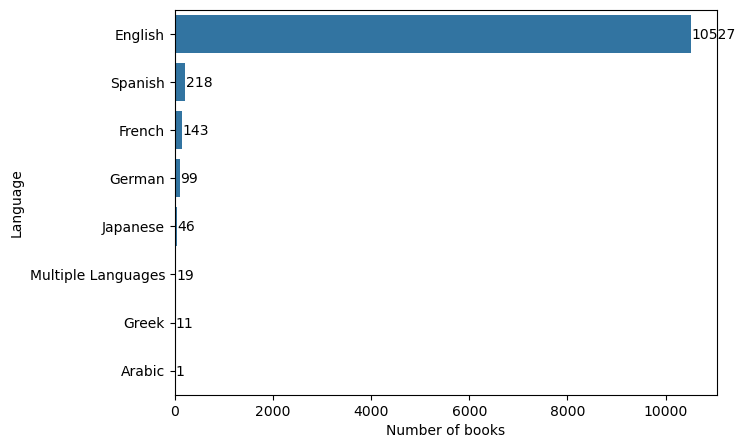

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(data=df, y="language_code", ax=ax, orient="h", order=df["language_code"].value_counts().index)
ax.set_xlabel("Number of books")
ax.set_ylabel("Language")
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", (p.get_width() + 10, p.get_y() + 0.5))
plt.savefig("languages_improved.pdf")

We will end here, but the above visualization is really wasteful of space. Furthermore, the label for the English count should not go over the line etc. Does it even make sense to include such a plot in the analysis? The main (only) thing it tells you is just that English has vastly more books in the Goodreads dataset than other languages, and for that you waste 4 inches of the column in your report. Again, this was included just as a showcase of graph features you should improve/consider (titles, labels, counts, orientation, save formats, tec.) not as an example of an informative graph.